# DREAM5 - SGBM, denormalized variable importance

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt

## Data paths

In [2]:
wd = os.getcwd().split('arboreto')[0] + 'arboreto/resources/dream5/'

net1_ex_path = wd + 'net1/net1_expression_data.tsv'
net1_tf_path = wd + 'net1/net1_transcription_factors.tsv'

net3_ex_path = wd + 'net3/net3_expression_data.tsv'
net3_tf_path = wd + 'net3/net3_transcription_factors.tsv'

net4_ex_path = wd + 'net4/net4_expression_data.tsv'
net4_tf_path = wd + 'net4/net4_transcription_factors.tsv'

## Dask client

In [3]:
from dask.distributed import Client, LocalCluster

In [4]:
client = Client(LocalCluster())

In [5]:
client

Client Scheduler: tcp://127.0.0.1:38103 Dashboard: http://127.0.0.1:8787,Cluster Workers: 88 Cores: 88 Memory: 135.08 GB


Use port forwarding to view the dashboard `$ ssh -L 8000:localhost:8787 nostromo`

In [86]:
client.shutdown()

## Infer networks (with meta)

In [49]:
def infer_network_and_meta(ex_path, tf_path, client):
    ex_matrix = load_expression_matrix(ex_path)
    gene_names = load_gene_names(ex_path)
    tf_names = load_tf_names(tf_path, gene_names)
    
    network_graph, meta_graph = create_graph(ex_matrix,
                                             gene_names,
                                             tf_names,
                                             "GBM",
                                             SGBM_KWARGS,
                                             'all',  # [200, 201, 202, 203, 204],
                                             early_stop_window_length=25,
                                             include_meta=True)
    
    result = client.compute([network_graph, meta_graph], sync=True)
    
    network_df = result[0]
    meta_df = result[1]
    
    return network_df, meta_df

In [50]:
%%time
net1, meta1 = infer_network_and_meta(net1_ex_path, net1_tf_path, client)

CPU times: user 34.7 s, sys: 10.4 s, total: 45.1 s
Wall time: 52.8 s


In [51]:
len(net1)

318874

In [52]:
meta1.head()

,n_estimators,target
0,568,G1
0,680,G2
0,482,G3
0,522,G4
0,595,G5


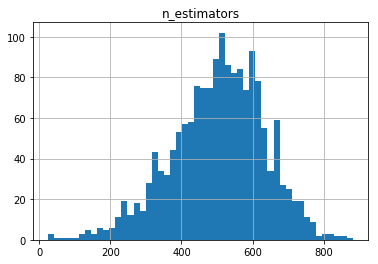

In [53]:
meta1.hist(bins=50)
plt.show()

## Correlate `n_estimators` with max `importance`

In [58]:
# net1['max_importance'] = net1.groupby(['target'])['importance'].transform(max)
# max_by_target_df = net1.groupby(['target'])['importance'].max().reset_index()
# top_3_by_target_df = net1.groupby(['target'])['importance'].nlargest(3).reset_index()
# net1.groupby(['target'])['importance'].nlargest(5).reset_index()
# net1_max_importance_by_n_rounds = meta1.merge(net1[['target', 'max_importance']].drop_duplicates(), how='left', on=['target'])
# net1_max_importance_by_n_rounds = meta1.merge(max_by_target_df, how='left', on=['target'])

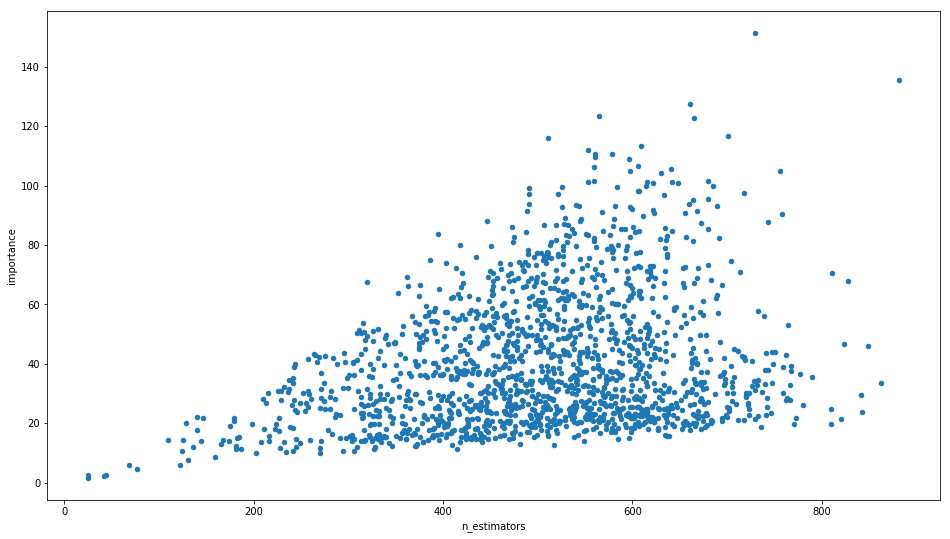

In [57]:
n = 1
meta1.merge(net1.groupby(['target'])['importance'].nlargest(n).reset_index(), 
            how='left', 
            on=['target']).plot.scatter(x='n_estimators', 
                                        y='importance', 
                                        figsize=(16, 9))
plt.show()

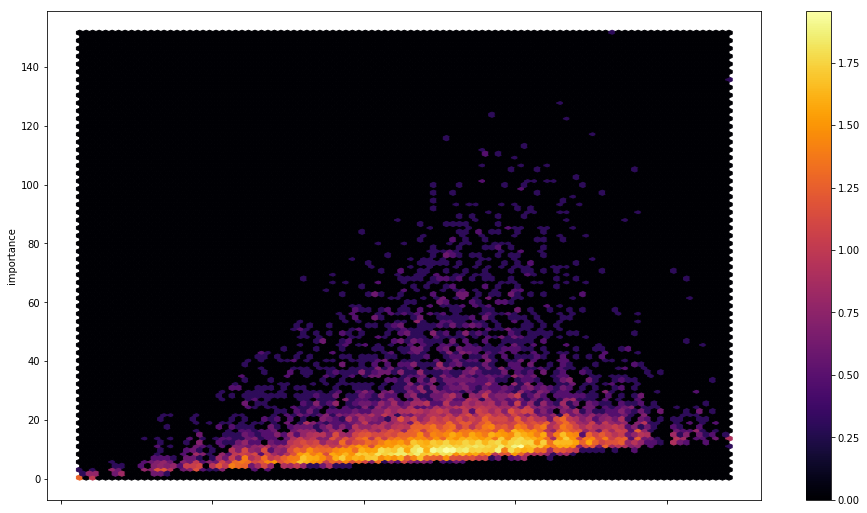

In [85]:
# cmap values: jet, coolwarm
# https://matplotlib.org/examples/color/colormaps_reference.html

n = 10
meta1.merge(net1.groupby(['target'])['importance'].nlargest(n).reset_index(), 
            how='left', 
            on=['target']).plot.hexbin(x='n_estimators', 
                                       y='importance',   
                                       bins='log',
                                       cmap=plt.get_cmap("inferno"),
                                       figsize=(16, 9))
plt.show()

# DAFUQ?

* what the hell does this mean? --> probably that the normalization doesn't make a lot of sense

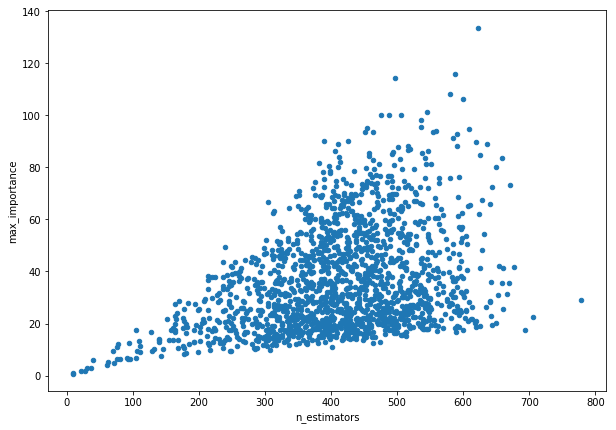

In [20]:
net1_max_importance_by_n_rounds.plot.scatter(x='n_estimators', y='max_importance', figsize=(10, 7))
plt.show()

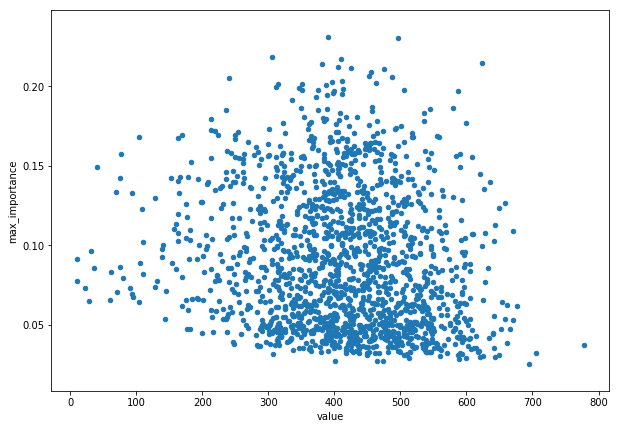

In [103]:
net1_max_importance_by_n_rounds.plot.scatter(x='value', y='max_importance', figsize=(10, 7))
plt.show()

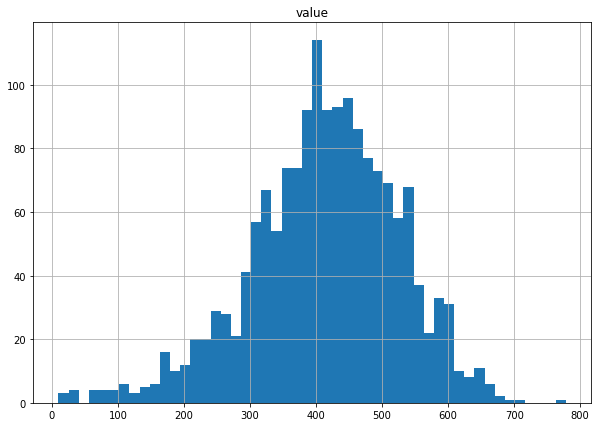

In [111]:
meta1.hist(bins=50, figsize=(10,7))
plt.show()

### Gradient boosting importances

> Using OOB early stopping, it does not make sense to normalize by dividing by the number of estimators in the ensemble, probably better to make a custom function for SGBM.

```
@property
def feature_importances_(self):
    """Return the feature importances (the higher, the more important the
       feature).

    Returns
    -------
    feature_importances_ : array, shape = [n_features]
    """
    self._check_initialized()

    total_sum = np.zeros((self.n_features_, ), dtype=np.float64)
    for stage in self.estimators_:
        stage_sum = sum(tree.feature_importances_
                        for tree in stage) / len(stage)
        total_sum += stage_sum

    importances = total_sum / len(self.estimators_)  # !!!
    return importances
```